## Shelter Animal Outcomes
### MIDS W207 Final Project
### Clay Miller, Roseanna Hopper, Yubo Zhang
### Exploratory Data Analysis

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

from sklearn import metrics
from sklearn.pipeline import Pipeline
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.base import BaseEstimator, TransformerMixin
from bokeh.charts import Bar, output_file, show, output_notebook
output_notebook()

%matplotlib inline

Loading BokehJS ...

In [3]:
# Load the data
data = pd.read_csv('../data/train.csv')
data['OutcomeSubtype'] = data['OutcomeSubtype'].fillna('')
data['Female'] = 'Female' in data['SexuponOutcome']
data['AgeuponOutcome'].fillna('', inplace = True)

def ageConvert(age):
    regexyear = '(\d+) year'
    regexmnth = '(\d+) month'
    regexwk = '(\d+) week'
    regexday = '(\d+) day'
    if re.match(regexyear, age):
        const = int(re.match(regexyear, age).groups()[0])
        return const*52
    elif re.match(regexmnth, age):
        const = int(re.match(regexmnth, age).groups()[0])
        return const*4.5 # a month is roughly 4.5 weeks
    elif re.match(regexwk, age):
        return int(re.match(regexwk, age).groups()[0])
    elif re.match(regexday, age):
        const = int(re.match(regexday, age).groups()[0])
        return const/7 #7 days in a week
    else:
        return None
    
data['ConvertedAge']=data['AgeuponOutcome'].apply(ageConvert)


def female(i):
    i = str(i)
    if i.find('Female') >= 0: return 'Female'
    if i.find('Unknown') >= 0: return 'Unknown'
    return 'Male'
data['Female'] = data.SexuponOutcome.apply(female)

def intact(i):
    i = str(i)
    if i.find('Intact') >= 0: return 'Intact'
    if i.find('Unknown') >= 0: return 'Unknown'
    return 'Spayed/Neutered'
data['Intact'] = data.SexuponOutcome.apply(intact)

def mixed_breed(i):
    i = str(i)
    if i.find('Mix') >= 0: return 'Mixed Breed'
    if i.find('/') >= 0: return 'Known Breed Combo'
    return 'Nonmixed'
data['MixedBreed'] = data.Breed.apply(mixed_breed)


def naming(i):
    if pd.isnull(i): return 'Unnamed'
    return 'Named'
data['Named'] = data.Name.apply(naming)

#Change all breed and color strings so that they are ordered consistently
#E.G. all "brown/black" and "black/brown" should become "black, brown"
def reorder(i):
    i = str(i)
    if i.find(" ") >= 0: i = i.replace(" ", "-")
    if i.find("/") >= 0: i = i.replace("/", " ")
    i = i.split()
    i = sorted(i)
    i = ' '.join(i)
    return i

data['OrderedColor'] = data.Color.apply(reorder)
data['OrderedBreed'] = data.Breed.apply(reorder)


In [ ]:
#Remove unnecessary variables
del data['AnimalID']
del data['Name']
del data['DateTime']
del data['OutcomeSubtype']
del data['AnimalType']
del data['SexuponOutcome']
del data['AgeuponOutcome']
del data['Color']

#One-hot encoding


# Set target and predictors
target = 'OutcomeType'
predictors = [c for c in data.columns if not c == target]

# Train/test split
X = data[predictors]
y = data[[target]]
X_train, X_dev, y_train, y_dev = train_test_split(X, y, random_state=2)

In [9]:
data.head()

,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color,TotalOutcome,Female,ConvertedAge,Intact,MixedBreed,Named,OrderedColor,OrderedBreed
0,Hambone,2/12/2014 18:22,Return_to_owner,,Dog,Neutered Male,1 year,Shetland Sheepdog Mix,Brown/White,Return_to_owner-,Male,52.0,Spayed/Neutered,Mixed Breed,Named,Brown White,Shetland-Sheepdog-Mix
1,Emily,10/13/2013 12:44,Euthanasia,Suffering,Cat,Spayed Female,1 year,Domestic Shorthair Mix,Cream Tabby,Euthanasia-Suffering,Female,52.0,Spayed/Neutered,Mixed Breed,Named,Cream-Tabby,Domestic-Shorthair-Mix
2,Pearce,1/31/2015 12:28,Adoption,Foster,Dog,Neutered Male,2 years,Pit Bull Mix,Blue/White,Adoption-Foster,Male,104.0,Spayed/Neutered,Mixed Breed,Named,Blue White,Pit-Bull-Mix
3,NaN,7/11/2014 19:09,Transfer,Partner,Cat,Intact Male,3 weeks,Domestic Shorthair Mix,Blue Cream,Transfer-Partner,Male,3.0,Intact,Mixed Breed,Unnamed,Blue-Cream,Domestic-Shorthair-Mix
4,NaN,11/15/2013 12:52,Transfer,Partner,Dog,Neutered Male,2 years,Lhasa Apso/Miniature Poodle,Tan,Transfer-Partner,Male,104.0,Spayed/Neutered,Known Breed Combo,Unnamed,Tan,Lhasa-Apso Miniature-Poodle


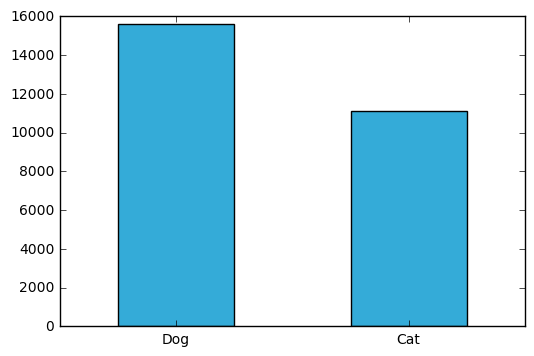

In [12]:
#A quick look at the variables

#Animal types
animal_type = data['AnimalType'].value_counts() 
animal_type.plot(kind='bar',color='#34ABD8',rot=0)

In [11]:
#Animal types
p = Bar(data, label='OutcomeType', values = 'AnimalType', agg='count', stack='AnimalType',
        title="Outcomes by Animal Type", legend='top_right')
show(p)

Loading BokehJS ...

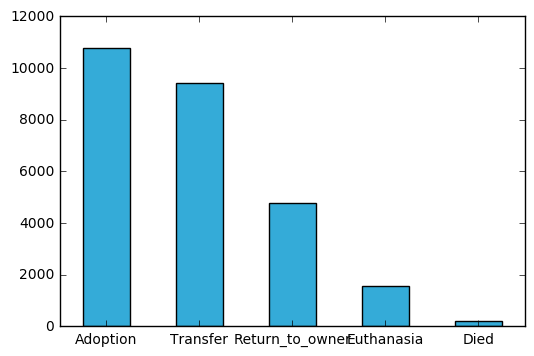

In [13]:
#Outcome types
outcome_type = data['OutcomeType'].value_counts() 
outcome_type.plot(kind='bar',color='#34ABD8',rot=0)

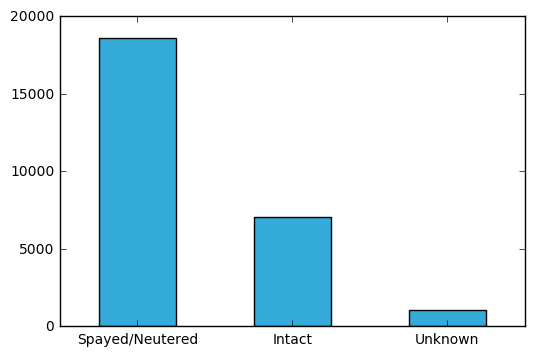

In [9]:
#Spayed/neutered
intact_type = data['Intact'].value_counts() 
intact_type.plot(kind='bar',color='#34ABD8',rot=0)

In [12]:
p = Bar(data, label='OutcomeType', values = 'Intact', agg='count', stack='Intact',
        title="Outcomes by Intact Status", legend='top_right')
show(p)

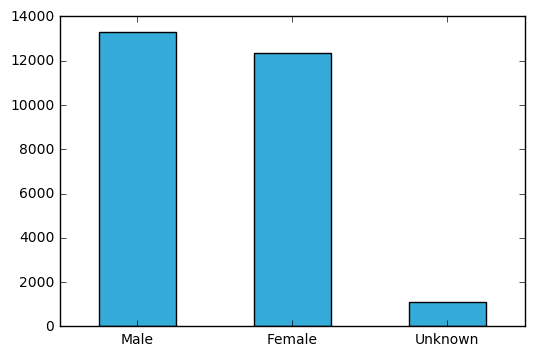

In [13]:
#Sex
intact_type = data['Female'].value_counts() 
intact_type.plot(kind='bar',color='#34ABD8',rot=0)

In [14]:
p = Bar(data, label='OutcomeType', values = 'Female', agg='count', stack='Female',
        title="Outcomes by Female", legend='top_right')
show(p)

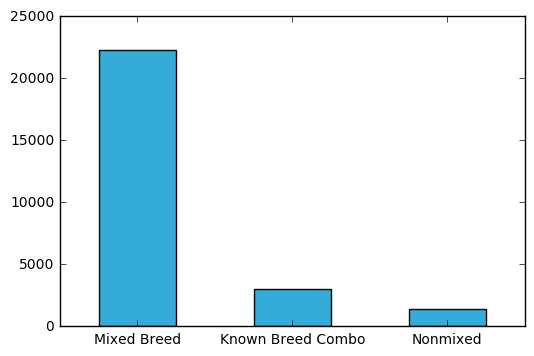

In [16]:
#Purebred/mixed

mixed_breed = data['MixedBreed'].value_counts() 
mixed_breed.plot(kind='bar',color='#34ABD8',rot=0)

In [17]:
p = Bar(data, label='OutcomeType', values = 'MixedBreed', agg='count', stack='MixedBreed',
        title="Outcomes by Breed Type", legend='top_right')
show(p)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000000109AF4E0>]], dtype=object)

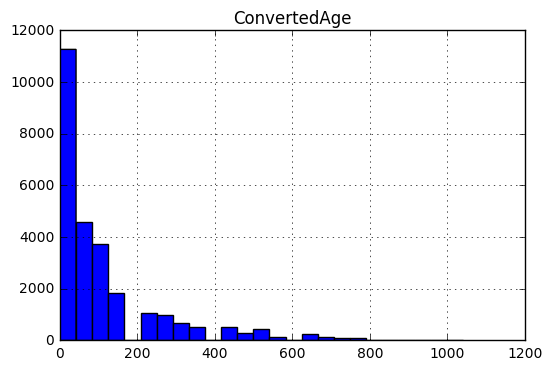

In [17]:
data.hist(column="ConvertedAge", bins=25)

In [107]:
p = Bar(data, label='OutcomeType', values = 'ConvertedAge', agg='mean',
        title="Outcomes by Age", legend='top_right')
show(p)

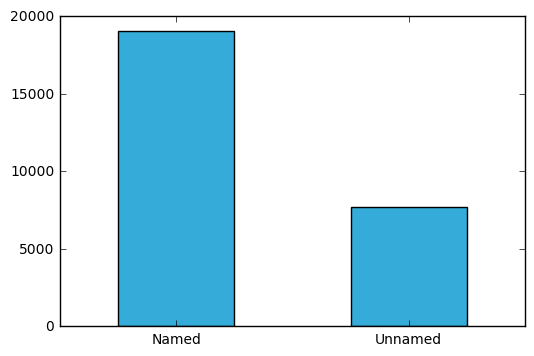

In [19]:
#Named/unnamed

name = data['Named'].value_counts() 
name.plot(kind='bar',color='#34ABD8',rot=0)

In [18]:
p = Bar(data, label='OutcomeType', values = 'Named', agg='count', stack='Named',
        title="Outcomes by Name Status", legend='top_right')
show(p)

In [88]:
OrderedColor = data.OrderedColor.unique()
print("Unique Colors" , (data.OrderedColor.value_counts() > 0).sum())
print(OrderedColor)

('Unique Colors', 275)
['Brown White' 'Cream-Tabby' 'Blue White' 'Blue-Cream' 'Tan' 'Black Tan'
 'Blue-Tabby' 'Brown-Tabby' 'Red White' 'White' 'Black' 'Silver' 'Brown'
 'Black Red' 'Cream White' 'Orange-Tabby White' 'Black White'
 'Brown-Brindle White' 'Black Brown' 'Orange-Tabby' 'Chocolate White'
 'Tan White' 'Cream-Tabby White' 'Blue' 'Calico' 'Torbie' 'Yellow'
 'Tricolor' 'Tortie' 'Blue-Tabby White' 'Gray White' 'Buff'
 'Brown-Tabby White' 'Red' 'Blue Tan' 'Seal-Point' 'Brown-Brindle' 'Gray'
 'White Yellow-Brindle' 'Fawn White' 'Flame-Point' 'Black-Tabby White'
 'Calico Tortie' 'Black Brown-Brindle' 'Silver Tan' 'Black Red-Tick'
 'Blue-Merle' 'Chocolate Tan' 'Sable' 'Brown-Merle White'
 'Brown-Tiger White' 'Liver White' 'Black Gray' 'Cream' 'Chocolate'
 'Blue-Point' 'Apricot White' 'Black Red-Merle' 'Blue-Merle White' 'Fawn'
 'Lynx-Point White' 'Black Fawn' 'Red-Tick White' 'Buff Tan'
 'Brown-Brindle Red-Tick' 'Lilac-Point' 'Buff White' 'Tortie-Point'
 'Lynx-Point' 'Tortie White' 

In [89]:
OrderedBreed = data.OrderedBreed.unique()
print("Unique Breeds" , (data.OrderedBreed.value_counts() > 0).sum())
print(OrderedBreed)

('Unique Breeds', 1143)
['Shetland-Sheepdog-Mix' 'Domestic-Shorthair-Mix' 'Pit-Bull-Mix' ...,
 'English-Bulldog French-Bulldog' 'Boxer Vizsla'
 'Australian-Kelpie German-Shepherd']


In [17]:
def main():
    print "Number of observations: ", len(data.index)
    print "Number of columns: ", len(data.columns)
    print "Headers: ", data.columns.values

if __name__ == "__main__":
    main()



Number of observations:  26729
Number of columns:  17
Headers:  ['Name' 'DateTime' 'OutcomeType' 'OutcomeSubtype' 'AnimalType'
 'SexuponOutcome' 'AgeuponOutcome' 'Breed' 'Color' 'TotalOutcome' 'Female'
 'ConvertedAge' 'Intact' 'MixedBreed' 'Named' 'OrderedColor' 'OrderedBreed']


### LOGISTIC REGRESSION

In [15]:
print X_train.shape
print X_dev.shape
print y_train.shape
print y_dev.shape

(20046, 16)
(6683, 16)
(20046, 1)
(6683, 1)


In [11]:
def lr_model():
    
    #Generate logistic regression
    def logit_reg(X_train, X_dev):
        logit_reg = LogisticRegression(penalty="l2", multi_class='multinomial')  
        
        #Test C within [0.001, 10]
        param_domain = [0.001, 0.01, 0.1, 0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 1.75, 2.0, 5.0, 10.0]
        param_dict = dict(C = param_domain)

        #Initialize GridSearchCV to identify the optimal parameter values
        gridsearch = GridSearchCV(logit_reg, param_dict)
        gridsearch.fit(X_train, y_train)
        
        #Generate model at the best C value
        C = gridsearch.best_params_["C"]
        print "Train data: Logistic Regression score at C=%.3f: %f" % (C, gridsearch.best_score_)
        print ('\n' * 1)
        logit_reg = LogisticRegression(C=C, penalty="l2")
        logit_reg.fit(X_train, y_train)

        #Predict on the X_dev set
        logit_reg_dev = logit_reg.predict(X_dev)

        #Generate classification report
        print "Classification Report:"
        print " "
        print classification_report(y_dev, logit_reg_dev, target_names=y_dev)
        print "Dev data: Logistic Regression score at C=%.3f: %f" % (C, metrics.f1_score(y_dev, logit_reg_dev, average="weighted"))    
        print ('\n' * 2)

        
        #Generate logistic regression and add the squared weight values to an array, at each C
        logit_reg_coeff = []
        for c in param_domain:
            logit_reg = LogisticRegression(C=c, penalty="l2") 
            logit_reg.fit(X_train, y_train)
            squared_weights = []
            squared_weights.append(c)                       
            for i in range(0, 4):
                [squared_weights.append(np.sum(np.power(logit_reg.coef_[i], 2)))]
            logit_reg_coeff.append(squared_weights)
            
        coeff = np.asarray(logit_reg_coeff, dtype = "object")

    
        #Plot C vs. squared weights
        fig, axes = plt.subplots(nrows=2, ncols=2)
        i = 0
        for ax in axes.ravel():
            ax.plot(coeff[:, 0], coeff[:, i], "b")
            ax.set_xscale("log")
            ax.set_title(y_train[i])
            ax.set_xlabel("C")
            ax.set_ylabel("Sum of Sq. Weights")
            i += 1
        fig.tight_layout()
        
    

    logit_reg(X_train, X_dev)
    
lr_model()    

IndexError: too many indices for array